In [8]:
%matplotlib widget

import numpy as np
from dataclasses import dataclass

#########################################

class BodySegments2D:
    """
    Class containing the segments of a polygonal body. 
    To create an instance a set of indices have to be passed on.
    """
    def __init__(self,idx1,vertices):
        assert vertices.shape[1]==2
        ## circular shift to get second set of indices
        idx2 = np.roll(idx1,-1)
        ## first set of vertices
        self.ver1 = vertices[idx1,:].view()
        ## second set of vertices
        self.ver2 = vertices[idx2,:].view()
        self.nsegm = self.ver1.shape[0]

#########################################

class MagPolyBodies2D:
    """
    Class containing a set of polygonal bodies described by their segments and all vertices.
    To create an instance, input an array of vectors of indices 
    (of vertices) for each body and the array of all the vertices.
    """
    def __init__(self,bodyindices,allvert):
        assert allvert.shape[1]==2
        ## array of all vertices for all bodies
        self.allvert = allvert
        # bodyindices must be an array of arrays
        assert type(bodyindices[0])==np.ndarray
        N=bodyindices.size
        ## array of bodies defined by their vertices
        self.bo = np.zeros(N,dtype=np.object)
        for i in range(N):
            self.bo[i] = BodySegments2D(bodyindices[i],self.allvert)

#########################################

@dataclass
class MagnetizVector: 
    """
    Class containing the components of a magnetization vector, 
    i.e., module, inclination and declination angles.
    """  
    mod: float
    Ideg: float
    Ddeg: float

## mv = MagnetizVector(2.0,3.2,4.9)
#########################################


In [9]:

import numpy as np

############################################################3

def magcomp(modJind,Iind,Dind,modJrem,Irem,Drem,C):
    """
    Vector addition of magnetic (remnant + induced) components.
    """    
    ## Induced magnetization components
    Jix = modJind*np.cos(Iind)*np.cos(C-Dind)
    Jiy = modJind*np.cos(Iind)*np.sin(C-Dind)
    Jiz = modJind*np.sin(Iind)

    ## Remnant magnetization components
    Jrx = modJrem*np.cos(Irem)*np.cos(C-Drem)
    Jry = modJrem*np.cos(Irem)*np.sin(C-Drem)
    Jrz = modJrem*np.sin(Irem)

    ## Vector addition    
    Jtotx = Jix+Jrx
    Jtoty = Jiy+Jry
    Jtotz = Jiz+Jrz
   
    return Jtotx,Jtoty,Jtotz

##############################################

def convert_H_to_B_nT( H_Am ):
    """
    Convert from the field H (A/m) to B (nT).
    """
    ## permeabilita' del vuoto 
    ## muzero = 4.0 * pi * 10.0^-7
    ## B nanoTesla
    ## B_nT = ( muzero * H_Am ) * 10.0^9
    B_nT =  np.pi * 400.0 * H_Am 
    return B_nT

###############################################

def convert_B_nT_to_H( B_nT ):
    """
    Convert from the field B (nT) to H (A/m).
    """
    H_Am = B_nT / (np.pi * 400.0)
    return H_Am

###############################################


In [10]:
import numpy as np
import warnings

#########################################        

def _cotangent(theta):
    return 1.0/np.tan(theta)

def _arccotangent(theta):
    assert theta != 0.0
    return np.arctan2(1,theta)


########################################################################

def tmagpolybodies2D(xzobs,Jinds,Jrems,northxax,bodies):
    """
    Total magnetic field (2D) for a set of polygonal bodies defined by their corners. 
    Takes into account both induced and remnant magnetization.
    Based on Talwani & Heitzler (1964), the default algorithm in Mag2Dpoly package. 
    """
    tmag = np.zeros(xzobs.shape[0])
    for ise in range(bodies.bo.size):
        tmag += tmagpoly2Dgen(xzobs,Jinds[ise],Jrems[ise],northxax,bodies.bo[ise])
    
    return tmag
    

###################################################################################

def tmagpolybodies2Dgen(xzobs,Jinds,Jrems,northxax,bodies,forwardtype):
    """
    Total magnetic field (2D) for a set of polygonal bodies defined by their corners. 
    Takes into account both induced and remnant magnetization.
    Generic version containing four different algorithm formulations ``forwardtype``, passed as a string:
    - "talwani"      --> Talwani & Heitzler (1964)
    - "talwani_red"  --> Talwani & Heitzler (1964) rederived from Kravchinsky et al. 2019
    - "krav"         --> Kravchinsky et al. (2019) rectified by Ghirotto et al. (2020)
    - "wonbev"       --> Won & Bevis (1987)
    """
    tmag = np.zeros(xzobs.shape[0])
    for ise in range(bodies.bo.size):
        tmag += tmagpoly2Dgen(xzobs,Jinds[ise],Jrems[ise],northxax,bodies.bo[ise],forwardtype)
    
    return tmag


###################################################################################

def checkanticlockwiseorder(body):
    """
    Check whether the polygonal body has segments ordered anticlockwise.
    """
    ## https://stackoverflow.com/questions/1165647/how-to-determine-if-a-list-of-polygon-points-are-in-clockwise-order
    ## https://www.element84.com/blog/determining-the-winding-of-a-polygon-given-as-a-set-of-ordered-points
    #
    # Check direction (anti)clockwise for a reference
    #   system like the following:
    #
    #   z
    #  /\ 
    #  |      2
    #  |   1     3
    #  |      4
    #  |
    #  -------------> x
    #
    encarea2=0.0
    for ise in range(body.nsegm):
        x1 = body.ver1[ise,0]
        z1 = body.ver1[ise,1] 
        x2 = body.ver2[ise,0]
        z2 = body.ver2[ise,1]
        encarea2 += (x2-x1)*(z2+z1)

    # anticlockwise -> encarea2 < 0.0
    # clockwise -> encarea2 > 0.0
    if encarea2<0.0:
        anticlockw=True
    else :
        anticlockw=False
    #
    # The reference system for the magnetic anomaly functions
    #   is reversed in z:
    #
    #  -------------> x
    #  |
    #  |      4
    #  |   1     3
    #  |      2
    #  \/
    #  z
    #
    # so, consequently, we flip the direction of
    # clockwise/anticlockwise:   !(anticlockw)   
    return  not(anticlockw)


###############################################################33

def tmagpoly2D(xzobs,Jind,Jrem,northxax,body,forwardtype):
    """
    Total magnetic field (2D) for a polygon defined by its corners. Takes into account both induced and remnant magnetization.
    Based on Talwani & Heitzler (1964), the default algorithm in pyMag2DPoly. 
    """
    aclockw = checkanticlockwiseorder(body)

    if aclockw==False:
        raise ValueError("tmagforwardpoly2D(): vertices *not* ordered anticlockwise. Aborting.")
   
    ##---------------------
    ## Get the angles
   
    ## check modules
    assert Jind.mod >= 0.0
    assert Jrem.mod >= 0.0

    ## `northxax` is the angle between geographic north and the positive x axis
    assert 0.0 <= northxax <= 360.0
    Cnorth = np.deg2rad(northxax)
    
    ## check angles
    assert -90.0 <= Jind.Ideg <= 90.0
    assert -90.0 <= Jrem.Ideg <= 90.0
    
    assert -180.0 <= Jind.Ddeg <= 180.0
    assert -180.0 <= Jrem.Ddeg <= 180.0

    # deg to rad
    Iind = np.deg2rad(Jind.Ideg)
    Dind = np.deg2rad(Jind.Ddeg)
    Irem = np.deg2rad(Jrem.Ideg)
    Drem = np.deg2rad(Jrem.Ddeg)

    # Calculation of Jx and Jz only for case != wonbev
    Jtotx,_,Jtotz = magcomp(Jind.mod,Iind,Dind,Jrem.mod,Irem,Drem,Cnorth)

    ##-------------------------------------
    ## Loop on observation points and segments
    nobs = xzobs.shape[0]
    totfield = np.zeros(nobs)

    ## loop on observation points
    for iob in range(nobs):
        
        xo = xzobs[iob,0]
        zo = xzobs[iob,1]

        ## loop on segments
        tsum = 0.0
        for ise in range(body.nsegm):

            x1 = body.ver1[ise,0]-xo
            z1 = body.ver1[ise,1]-zo
            x2 = body.ver2[ise,0]-xo
            z2 = body.ver2[ise,1]-zo

            tsum += tmagtalwani(x1,z1,x2,z2,Jtotx,Jtotz,Iind,Dind,Cnorth)
                          
        # convert field from A/m to nT
        totfield[iob] = convert_H_to_B_nT( tsum )

    return totfield

#######################################################################################

def tmagtalwani(x1,z1,x2,z2,Jx,Jz,Iind,Dind,C):
    """
    Total magnetic field (2D) for a line segment. Formulas from Talwani & Heitzler (1964).
    """    

    # Quantities for error definitions
    eps = np.finfo(np.float64).eps
    small = 1e4*eps
    anglelim = 0.995*np.pi

    #--------------
    x21 = x2-x1
    z21 = z2-z1
    s = np.sqrt(x21**2+z21**2)

    # Return 0 if two corners are too close
    if s < small :
        return 0.0

    # Get the angles
    theta1 = np.arctan2(z1,x1)
    theta2 = np.arctan2(z2,x2)
    
    # If z21 = 0.0 no contribution    
    if z21 != 0.0 :
        g = -x21/z21
    else :
        return 0.0

    phi = _arccotangent(g)

    thetadiff = theta2-theta1
    # In the case polygon sides cross the x axis
    if thetadiff < -np.pi :
        thetadiff = thetadiff + 2.0*np.pi
    elif thetadiff > np.pi :
        thetadiff = thetadiff - 2.0*np.pi
           
    # Error if a corner is too close to the observation point (calculation continues)
    # and the corner are slightly moved away
    if (x1 < small) and (z1 < small) :
        x1 = small
        z1 = small
        warnings.warn("A corner is too close to an observation point (calculation continues)")
    
    if (x2 < small) and (z2 < small) :
        x2 = small
        z2 = small
        warnings.warn("A corner is too close to an observation point (calculation continues)")

    ########
    r1 = np.sqrt(x1**2+z1**2)
    r2 = np.sqrt(x2**2+z2**2)

    flog = np.log(r2)-np.log(r1)
 
    # Error if the side is too close to the observation point (calculation continues)
    if abs(thetadiff) > anglelim :
        warnings.warn("A polygon side is too close to an observation point (calculation continues)")

    # vertical component
    V = 2.0*np.sin(phi) * (Jx*( (thetadiff)*np.cos(phi) + np.sin(phi)*flog) - \
                      Jz*( (thetadiff)*np.sin(phi) - np.cos(phi)*flog) )

    # horizonatal component
    H = 2.0*np.sin(phi) * (Jx*( (thetadiff)*np.sin(phi) - np.cos(phi)*flog) + \
                      Jz*( (thetadiff)*np.cos(phi) + np.sin(phi)*flog) )

    # Divided by 4π to take into account algorithm formulation in emu units 
    totfield = (1.0/(4.0*np.pi)) * (H*np.cos(Iind)*np.cos(C-Dind) + V*np.sin(Iind))
    
    return totfield 


###########################################################################

def tmagpoly2Dgen(xzobs,Jind,Jrem,northxax,body,forwardtype) :
    """
    Total magnetic field (2D) for a polygon defined by its corners. Takes into account both induced and remnant magnetization.
    Generic version containing four different algorithm formulations ``forwardtype``, passed as a string:
    - "talwani"      --> Talwani & Heitzler (1964)
    - "talwani_red"  --> Talwani & Heitzler (1964) rederived from Kravchinsky et al. 2019
    - "krav"         --> Kravchinsky et al. (2019) rectified by Ghirotto et al. (2020)
    - "wonbev"       --> Won & Bevis (1987)
    """

    ## LOOPING on segments MUST be in ANTI-CLOCKWISE order
    aclockw = checkanticlockwiseorder(body)

    if aclockw==False:
        raise ValueError("tmagforwardpoly2D(): vertices *not* ordered clockwise. Aborting.")
   
    ##---------------------
    ## Get the angles
   
    ## check modules
    assert Jind.mod >= 0.0
    assert Jrem.mod >= 0.0

    ## `northxax` is the angle between geographic north and the positive x axis
    assert 0.0 <= northxax <= 360.0
    Cnorth = np.deg2rad(northxax)
    
    ## check angles
    assert -90.0 <= Jind.Ideg <= 90.0
    assert -90.0 <= Jrem.Ideg <= 90.0
    
    assert -180.0 <= Jind.Ddeg <= 180.0
    assert -180.0 <= Jrem.Ddeg <= 180.0

    # check right forwardtype
    if (forwardtype != "talwani") and (forwardtype != "talwani_red") and (forwardtype != "krav") and (forwardtype != "wonbev"):
        raise ValueError("tmagforwardpoly2D(): [forwardtype] must be 'talwani' or 'talwani_red' or 'krav' or 'wonbev'")
    
    # deg to rad
    Iind = np.deg2rad(Jind.Ideg)
    Dind = np.deg2rad(Jind.Ddeg)
    Irem = np.deg2rad(Jrem.Ideg)
    Drem = np.deg2rad(Jrem.Ddeg)

    # Calculation of Jx and Jz only for case != wonbev
    if forwardtype != "wonbev":
        Jtotx,_,Jtotz = magcomp(Jind.mod,Iind,Dind,Jrem.mod,Irem,Drem,Cnorth)
    
    ##-------------------------------------
    ## Loop on observation points and segments
    nobs = xzobs.shape[0]
    totfield = np.zeros(nobs)

    ## loop on observation points
    for iob in range(nobs):
        
        xo = xzobs[iob,0]
        zo = xzobs[iob,1]

        ## loop on segments
        tsum = 0.0
        for ise in range(body.nsegm):

            x1 = body.ver1[ise,0]-xo
            z1 = body.ver1[ise,1]-zo
            x2 = body.ver2[ise,0]-xo
            z2 = body.ver2[ise,1]-zo

            if forwardtype == "talwani":
                tsum += tmagtalwani(x1,z1,x2,z2,Jtotx,Jtotz,Iind,Dind,Cnorth)

            elif forwardtype == "talwani_red":
                tsum += tmagtalwanired(x1,z1,x2,z2,Jtotx,Jtotz,Iind,Dind,Cnorth)

            elif forwardtype == "krav":
                tsum += tmagkrav(x1,z1,x2,z2,Jtotx,Jtotz,Iind,Dind,Cnorth)

            elif forwardtype == "wonbev":
                tsum += tmagwonbev(x1,z1,x2,z2,Jind.mod,Jrem.mod,Iind,Dind,Irem,Drem,Cnorth)
                          
        # convert field from A/m to nT
        totfield[iob] = convert_H_to_B_nT( tsum )

    return totfield

########################################################################

def tmagkrav(x1,z1,x2,z2,Jtotx,Jtotz,Iind,Dind,Cnorth):
    """
    Total magnetic field (2D) for a line segment. Formulas from Kravchinsky et al (2019) rectified by Ghirotto et al. (2021). 
    """
    
    # Quantities for error definitions
    eps = np.finfo(np.float64).eps
    small = 1e4*eps
    anglelim = 0.995*np.pi

    #--------------
    x21 = x2-x1
    z21 = z2-z1
    tmpgamma = np.sqrt(x21**2+z21**2)

    # Return 0 if two corners are too close
    if tmpgamma < small :
        return 0.0

    # check if den != 0.0
    if tmpgamma!=0.0 :
        gammax = x21 / tmpgamma
        gammaz = z21 / tmpgamma
    else :
        return 0.0    
    
    # if the segment is horizontal it provides no contribution!
    if z21==0.0:
        return 0.0
    
    #------------
    g = x21/z21

    if x1 >= g*z1 :
        delta = 1.0
    elif x1 < g*z1 :
        delta = -1.0

    #--------------------
    # Get the angles
    alpha1 = np.arctan2(delta*(z1+g*x1),(x1-g*z1))
    alpha2 = np.arctan2(delta*(z2+g*x2),(x2-g*z2))
    
    #In the case polygon sides cross the x axis
    alphadiff = alpha2 - alpha1
    if alphadiff < -np.pi :
        alphadiff = alphadiff + 2.0*np.pi
    elif alphadiff > np.pi :
        alphadiff = alphadiff - 2.0*np.pi

    # Error if a corner is too close to the observation point (calculation continues)
    # and the corner are slightly moved away
    if (x1 < small) and (z1 < small) :
        x1 = small
        z1 = small
        warnings.warn("A corner is too close to an observation point (calculation continues)")
    
    if (x2 < small) and (z2 < small) :
        x2 = small
        z2 = small
        warnings.warn("A corner is too close to an observation point (calculation continues)")

        
    r1 = np.sqrt(x1**2+z1**2)
    r2 = np.sqrt(x2**2+z2**2)

    lor21 = np.log(r2)-np.log(r1)

    # Error if the side is too close to the observation point (calculation continues)
    if abs(alphadiff) > anglelim :
        warnings.warn("A polygon side is too close to an observation point (calculation continues)")
  
    #--------------------
    P = gammaz*gammax*lor21 + delta*(gammaz**2)*(alphadiff)
    Q = (gammaz**2)*lor21 - delta*gammax*gammaz*(alphadiff)
    
    ## horizonatl and vertical field components
    H = 1.0/(2.0*np.pi) * (Jtotz*Q + Jtotx*P)
    V = 1.0/(2.0*np.pi) * (Jtotx*Q - Jtotz*P)
    
    ## total field anomaly 
    totfield = V*np.sin(Iind)+H*np.cos(Iind)*np.cos(Cnorth-Dind)

    return totfield

########################################################################################

def tmagtalwanired(x1,z1,x2,z2,Jx,Jz,Iind,Dind,C):
    """ 
    Total magnetic field (2D) for a ribbon. Talwani & Heitzler (1964) modified by Kravchinsky et al. (2019).
    """
    # Quantities for error definitions
    eps = np.finfo(np.float64).eps
    small = 1e4*eps
    anglelim = 0.995*np.pi
    
    #--------------
    x21 = x2-x1
    z21 = z2-z1
    s = np.sqrt(x21**2+z21**2)
    
    # Return 0 if two corners are too close
    if s < small :
        return 0.0

    # if the segment is horizontal it provides no contribution!
    if z21 != 0.0:
        g = -x21/z21
    else:
        return 0.0

    phi = _arccotangent(g)
    
    den1 = x1+z1*_cotangent(phi)
    den2 = x2+z2*_cotangent(phi)
    num1 = z1-x1*_cotangent(phi)
    num2 = z2-x2*_cotangent(phi)

    # Controls on signs of atan argument (abs in den1 and den2)
    #-----------------------
    if den1 < 0.0 : 
        den1 = -den1
        delta = -1.0
        theta1 = np.arctan2(num1,den1)
    else :
        delta = 1.0
        theta1 = np.arctan2(num1,den1)

    if den2 < 0.0 :
        den2 = -den2
        theta2 = np.arctan2(num2,den2)
    else :
        theta2 = np.arctan2(num2,den2)        

    #-----------------------

    # In the case polygon sides cross the x axis
    thetadiff = theta2-theta1
    if thetadiff < -np.pi :
        thetadiff = thetadiff + 2.0*np.pi
    elif thetadiff > np.pi :
        thetadiff = thetadiff - 2.0*np.pi

    # Error if a corner is too close to the observation point (calculation continues)
    # and the corner are slightly moved away
    if (x1 < small) and (z1 < small) :
        x1 = small
        z1 = small
        warnings.warn("A corner is too close to an observation point (calculation continues)")
    
    if (x2 < small) and (z2 < small) :
        x2 = small
        z2 = small
        warnings.warn("A corner is too close to an observation point (calculation continues)")

    ########  
    r1 = np.sqrt(x1**2+z1**2)
    r2 = np.sqrt(x2**2+z2**2)

    flog = np.log(r2)-np.log(r1)
    
    # Error if the side is too close to the observation point (calculation continues)
    if abs(thetadiff) > anglelim :
        warnings.warn("A polygon side is too close to an observation point (calculation continues)")

        
    # vertical component    
    V = 2.0*np.sin(phi) * (Jx * (delta*(thetadiff)*np.cos(phi) + np.sin(phi)*flog)- \
                    Jz * (delta*(thetadiff)*np.sin(phi) - np.cos(phi)*flog) )
 
    # horizontal component
    H = 2.0*np.sin(phi) * (Jx * (delta*(thetadiff)*np.sin(phi) - np.cos(phi)*flog)+ \
                    Jz * (delta*(thetadiff)*np.cos(phi) + np.sin(phi)*flog) )
    
    ## total field anomaly divided by 4π to take into account algorithm formulation in emu units
    totfield = (1.0/(4.0*np.pi)) * (H*np.cos(Iind)*np.cos(C-Dind) + V*np.sin(Iind))
    
    return totfield  


#######################################################################################################################

def tmagwonbev(x1,z1,x2,z2,modJind,modJrem,Iind,Dind,Irem,Drem,C):
    """ 
    Total magnetic field (2D) for a line segment. Formulas from Won & Bevis (1987).
    """

    
    # Quantities for error definitions
    eps = np.finfo(np.float64).eps
    small = 1e4*eps
    anglelim = 0.995*np.pi

    # β is angle among North and profle direction
    betai = Dind - C + np.pi/2
    betar = Drem - C + np.pi/2
    
    #-------------------
    x21 = x2-x1
    z21 = z2-z1

    R  = np.sqrt(x21**2+z21**2)
    # Return 0 if two corners are too close
    if R < small :
        return 0.0

    # Error if a corner is too close to the observation point (calculation continues)
    # and the corner are slightly moved away
    if (x1 < small) and (z1 < small) :
        x1 = small
        z1 = small
        warnings.warn("A corner is too close to an observation point (calculation continues)")
    
    if (x2 < small) and (z2 < small) :
        x2 = small
        z2 = small
        warnings.warn("A corner is too close to an observation point (calculation continues)")

    ###
    r1 = np.sqrt(x1**2+z1**2)
    r2 = np.sqrt(x2**2+z2**2)

    lor21 = np.log(r2) - np.log(r1)

    theta1 = np.arctan2(z1,x1) 
    theta2 = np.arctan2(z2,x2)

    # In the case polygon sides cross the x axis
    if np.sign(z1) != np.sign(z2):
        test = x1*z2 - x2*z1
        if test > 0.0 :
            if z1 >= 0.0 :
                theta2 = theta2 + 2*np.pi
        elif test < 0.0 :
            if z2 >= 0.0 :
                theta1 = theta1 + 2*np.pi
        else :
            return 0.0 

    # Error if the side is too close to the observation point (calculation continues)
    thetadiff = theta1-theta2
    if abs(thetadiff) > anglelim :
        warnings.warn("A polygon side is too close to an observation point (calculation continues)")

    #------------------------
    
    P = (1/R**2)*(x1*z2 - x2*z1)*(((x1*x21 - z1*z21)/(r1**2))- \
                                 ((x2*x21 - z2*z21)/(r2**2)))

    Q = (1/R**2)*(x1*z2 - x2*z1)*(((x1*z21 + z1*x21)/(r1**2))- \
                                 ((x2*z21 + z2*x21)/(r2**2)))
    
    if x21 != 0.0 :
        g = z21/x21
        derZz = ((x21**2)/(R**2))*((theta1 - theta2) + g*lor21) - P
        derZx = -((x21*z21)/(R**2))*((theta1 - theta2) + g*lor21) + Q
        derXz = -((x21**2)/(R**2))*(g*(theta1 - theta2) - lor21) + Q
        derXx = ((x21*z21)/(R**2))*(g*(theta1 - theta2) - lor21) + P
        
    else :

        derZz = -P
        derZx = -((z21**2)/(R**2))*lor21 + Q
        derXz = Q
        derXx = ((z21**2)/(R**2))*(theta1 - theta2) + P  

    # Magnetic strenght components due to induced magnetization
    DELTAHzind = 2.0*modJind*(np.sin(Iind)*derZz + np.sin(betai)*np.cos(Iind)*derZx) 
    DELTAHxind = 2.0*modJind*(np.sin(Iind)*derXz + np.sin(betai)*np.cos(Iind)*derXx) 

    # Magnetic strenght components due to remnant magnetization
    DELTAHzrem = 2.0*modJrem*(np.sin(Irem)*derZz + np.sin(betar)*np.cos(Irem)*derZx) 
    DELTAHxrem = 2.0*modJrem*(np.sin(Irem)*derXz + np.sin(betar)*np.cos(Irem)*derXx) 

    DELTAHztot = DELTAHzind + DELTAHzrem
    DELTAHxtot = DELTAHxind + DELTAHxrem

    ## total field anomaly divided by 4π to take into account algorithm formulation in emu units
    DELTAHtot = -(1.0/(4.0*np.pi))*(DELTAHztot*np.sin(Iind) + DELTAHxtot*np.sin(betai)*np.cos(Iind))
   
    return DELTAHtot

###################################################################################



In [11]:

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from ipywidgets import widgets
import math
import numpy as np

# Load initial points
initial_points = [
    (500, 3000),
    (1000, 4000),
    (300, 3000),
    (6000, 1000),
]

points = []
point_coords = [initial_points]
selected_line_index = 0

def plot_initial_points():
    for x, y in initial_points:
        point, = ax.plot(x, y, marker='o', markersize=10)
        points.append(point)
        #point_coords.append((x, y))
    inclination_slider = create_inclination_slider(len(inclination_sliders) + 1)
    inclination_sliders.append(inclination_slider)
    
    declination_slider = create_declination_slider(len(declination_sliders) + 1)
    declination_sliders.append(declination_slider)
    
    intensity_slider = create_intensity_slider(len(intensity_sliders) + 1)
    intensity_sliders.append(intensity_slider)    
    display(intensity_slider)    
    display(inclination_slider)
    display(declination_slider)

def find_closest_point(x, y, threshold=1.0):
    min_distance = float('inf')
    closest_point = None
    closest_index = None
    
    for i, (px, py) in enumerate(point_coords[-1]):
        distance = ((px - x) ** 2 + (py - y) ** 2) ** 0.5
        if distance < min_distance and distance < threshold:
            min_distance = distance
            closest_point = points[i]
            closest_index = i
            
    return closest_point, closest_index

def on_click(event):
    global points, point_coords
    x, y = event.xdata, event.ydata
    threshold = 200.0

    closest_point, closest_index = find_closest_point(x, y, threshold)

    if closest_point is not None:
        closest_point.set_data(x, y)
        point_coords[-1][closest_index] = (x, y)
    else:
        point, = ax.plot(x, y, marker='o', markersize=10)
        points.append(point)
        point_coords[-1].append((x, y))

    update_line()

def clockwise_sort(points):
    if len(points) < 2:
        return points

    centroid_x = sum(p[0] for p in points) / len(points)
    centroid_y = sum(p[1] for p in points) / len(points)

    def angle(point):
        dx, dy = point[0] - centroid_x, point[1] - centroid_y
        return math.atan2(dy, dx)

    sorted_points = sorted(points, key=angle, reverse=True)
    return sorted_points

def update_line():
    global points, point_coords

    # Clear the plot
    ax.clear()
    ax.set_xlim(0, 20000)
    ax.set_ylim(10000, 0)
    ax.set_xlabel('East (m)')
    ax.set_ylabel('Depth (m)')
    # Plot all the lines
    for line_coords in point_coords:
        if len(line_coords) < 2:
            continue
        sorted_points = clockwise_sort(line_coords)
        sorted_points.append(sorted_points[0])
        ax.plot(*zip(*sorted_points),marker='o', linestyle='-', linewidth=2, zorder=-1)

    # Update the current line
    if len(point_coords[-1]) < 2:
        line.set_data([], [])
        fig.canvas.draw()
        return

    sorted_points = clockwise_sort(point_coords[-1])
    sorted_points.append(sorted_points[0])

    point_coords[-1] = sorted_points[:-1]
    points = [points[point_coords[-1].index(coord)] for coord in sorted_points[:-1]]

    line.set_data(list(zip(*sorted_points)))
    ax.plot(*zip(*sorted_points), linestyle='-', linewidth=2, zorder=-1)
    fig.canvas.draw()

def clear_points(_):
    global points, point_coords
    global inclination_sliders
    global declination_sliders
    global intensity_sliders

    for point in points:
        point.remove()
    points.clear()
    point_coords.clear()
    point_coords.append([])
    update_line()
    if len(inclination_sliders)>1:
        for slider in inclination_sliders[1:len(inclination_sliders)]:
            slider.close()
        for slider in declination_sliders[1:len(declination_sliders)]:
            slider.close()
        for slider in intensity_sliders[1:len(intensity_sliders)]:
            slider.close()
        inclination_sliders=[inclination_sliders[0]]
        declination_sliders=[declination_sliders[0]]
        intensity_sliders=[intensity_sliders[0]]


def clear_current_body(_):
    global points, point_coords
    global inclination_sliders
    global declination_sliders
    global intensity_sliders
    for point in points:
        point.remove()
    points.clear()
    point_coords[-1]=[]
    if len(inclination_sliders)>1:
        inclination_sliders[-1].close()
        declination_sliders[-1].close()
        intensity_sliders[-1].close()

        inclination_sliders=inclination_sliders[0:-1]
        declination_sliders=declination_sliders[0:-1]
        intensity_sliders=intensity_sliders[0:-1]
    update_line()    


def cal_mag(source,z_height,inten,inclin,declin):
    

    import sys
    # in this case local import
    sys.path.append("../")


    # angle with the North axis
    northxax = 90.0

    # number of observation
    Nobs = 101
    xzobs = np.transpose(np.vstack(( np.linspace(0.0,20000.0,Nobs), -z_height*np.ones(Nobs))))

    
    
    input_all=source
    nbod = len(input_all)
    bodyindices = np.empty(shape=(nbod,), dtype=np.object)
    vertices=[]
    Jd=[]
    Jm=[]
    indss=0
    for i in range(len(input_all)):
        inds = range(indss,len(np.array(input_all)[i])+indss)
        bodyindices[i] = np.array(inds)
        vertices= vertices+input_all[i]
        Jind = MagnetizVector(mod=inten[i],Ideg=inclin[i],Ddeg=declin[i])
        Jrem = MagnetizVector(mod=0,Ideg=90,Ddeg=0.0)
        Jd= Jd+[Jind]
        Jm= Jm+[Jrem]
        indss=len(np.array(input_all)[i])+indss

    # construct the poligonal body object
    pbody = MagPolyBodies2D(bodyindices,np.array(vertices))


    # type of forward algorithm
    forwardtype = "talwani"

    # compute total field
    # make Jind and Jrem arrays of objects (as many as there are bodies)
    Jindv = np.array(Jd) # we have one single body in this case
    Jremv = np.array(Jm) # we have one single body in this case
    tmag = tmagpolybodies2Dgen(xzobs,Jindv,Jremv,northxax,pbody,forwardtype)
    
    return tmag


def update_mag(_):
    global point_coords
    global height
    global inclination_sliders
    global declination_sliders
    global intensity_sliders
    source_body=point_coords[:]

    if len(point_coords)>len(inclination_sliders):
        source_body.remove([])
    Nobs = 101
    xzobs = np.transpose(np.vstack(( np.linspace(0.0,20000.0,Nobs), -1.0*np.ones(Nobs))))
    inclin_values = [slider.value for slider in inclination_sliders]
    declin_values = [slider.value for slider in declination_sliders]
    intensity_values = [slider.value for slider in intensity_sliders]
    
    tmag = cal_mag(source_body,height.value,intensity_values,inclin_values,declin_values)
    ax1.plot(xzobs[:,0],tmag,"o-")
    fig.canvas.draw()

def clear_mag(_):
    ax1.clear()
    ax1.set_xlim(0, 20000)
    ax1.plot([],[],"o-")
    ax1.set_xlabel('East (m)')
    ax1.set_ylabel('Total Magnetic Intensity (nT)')

# Create buttons
clear_button = widgets.Button(description='Clear All Mag Body')
clear_button.on_click(clear_points)

clear_current_button = widgets.Button(description='Clear Current Mag Body')
clear_current_button.on_click(clear_current_body)


update_mag_button = widgets.Button(description='Calculate Mag')
update_mag_button.on_click(update_mag)

clear_mag_button = widgets.Button(description='Clear Mag')
clear_mag_button.on_click(clear_mag)

height=widgets.IntSlider(
    min=0,
    max=10000,
    step=1000,
    description='Flight_height_above_ground:',
    value=1000
)
inclination_sliders = []
declination_sliders = []
intensity_sliders = []


def create_intensity_slider(body_index):
    slider = widgets.IntSlider(
        min=0,
        max=10,
        step=1,
        description=f'Mangetization {body_index}:',
        value=4
    )
    return slider

def create_inclination_slider(body_index):
    slider = widgets.IntSlider(
        min=-90,
        max=90,
        step=5,
        description=f'Inclination {body_index}:',
        value=90
    )
    return slider

def create_declination_slider(body_index):
    slider = widgets.IntSlider(
        min=-90,
        max=90,
        step=5,
        description=f'Declination {body_index}:',
        value=0
    )
    return slider

def add_body_with_sliders(_):
    global point_coords
    global inclination_sliders
    global declination_sliders
    global intensity_sliders
    
    point_coords.append([])
    update_line()
    
    inclination_slider = create_inclination_slider(len(inclination_sliders) + 1)
    inclination_sliders.append(inclination_slider)
    
    declination_slider = create_declination_slider(len(declination_sliders) + 1)
    declination_sliders.append(declination_slider)

    intensity_slider = create_intensity_slider(len(intensity_sliders) + 1)
    intensity_sliders.append(intensity_slider)
    
    display(intensity_slider)    
    display(inclination_slider)
    display(declination_slider)

add_body_with_sliders_button = widgets.Button(description='Add Mag Body')
add_body_with_sliders_button.on_click(add_body_with_sliders)



<IPython.core.display.Javascript object>


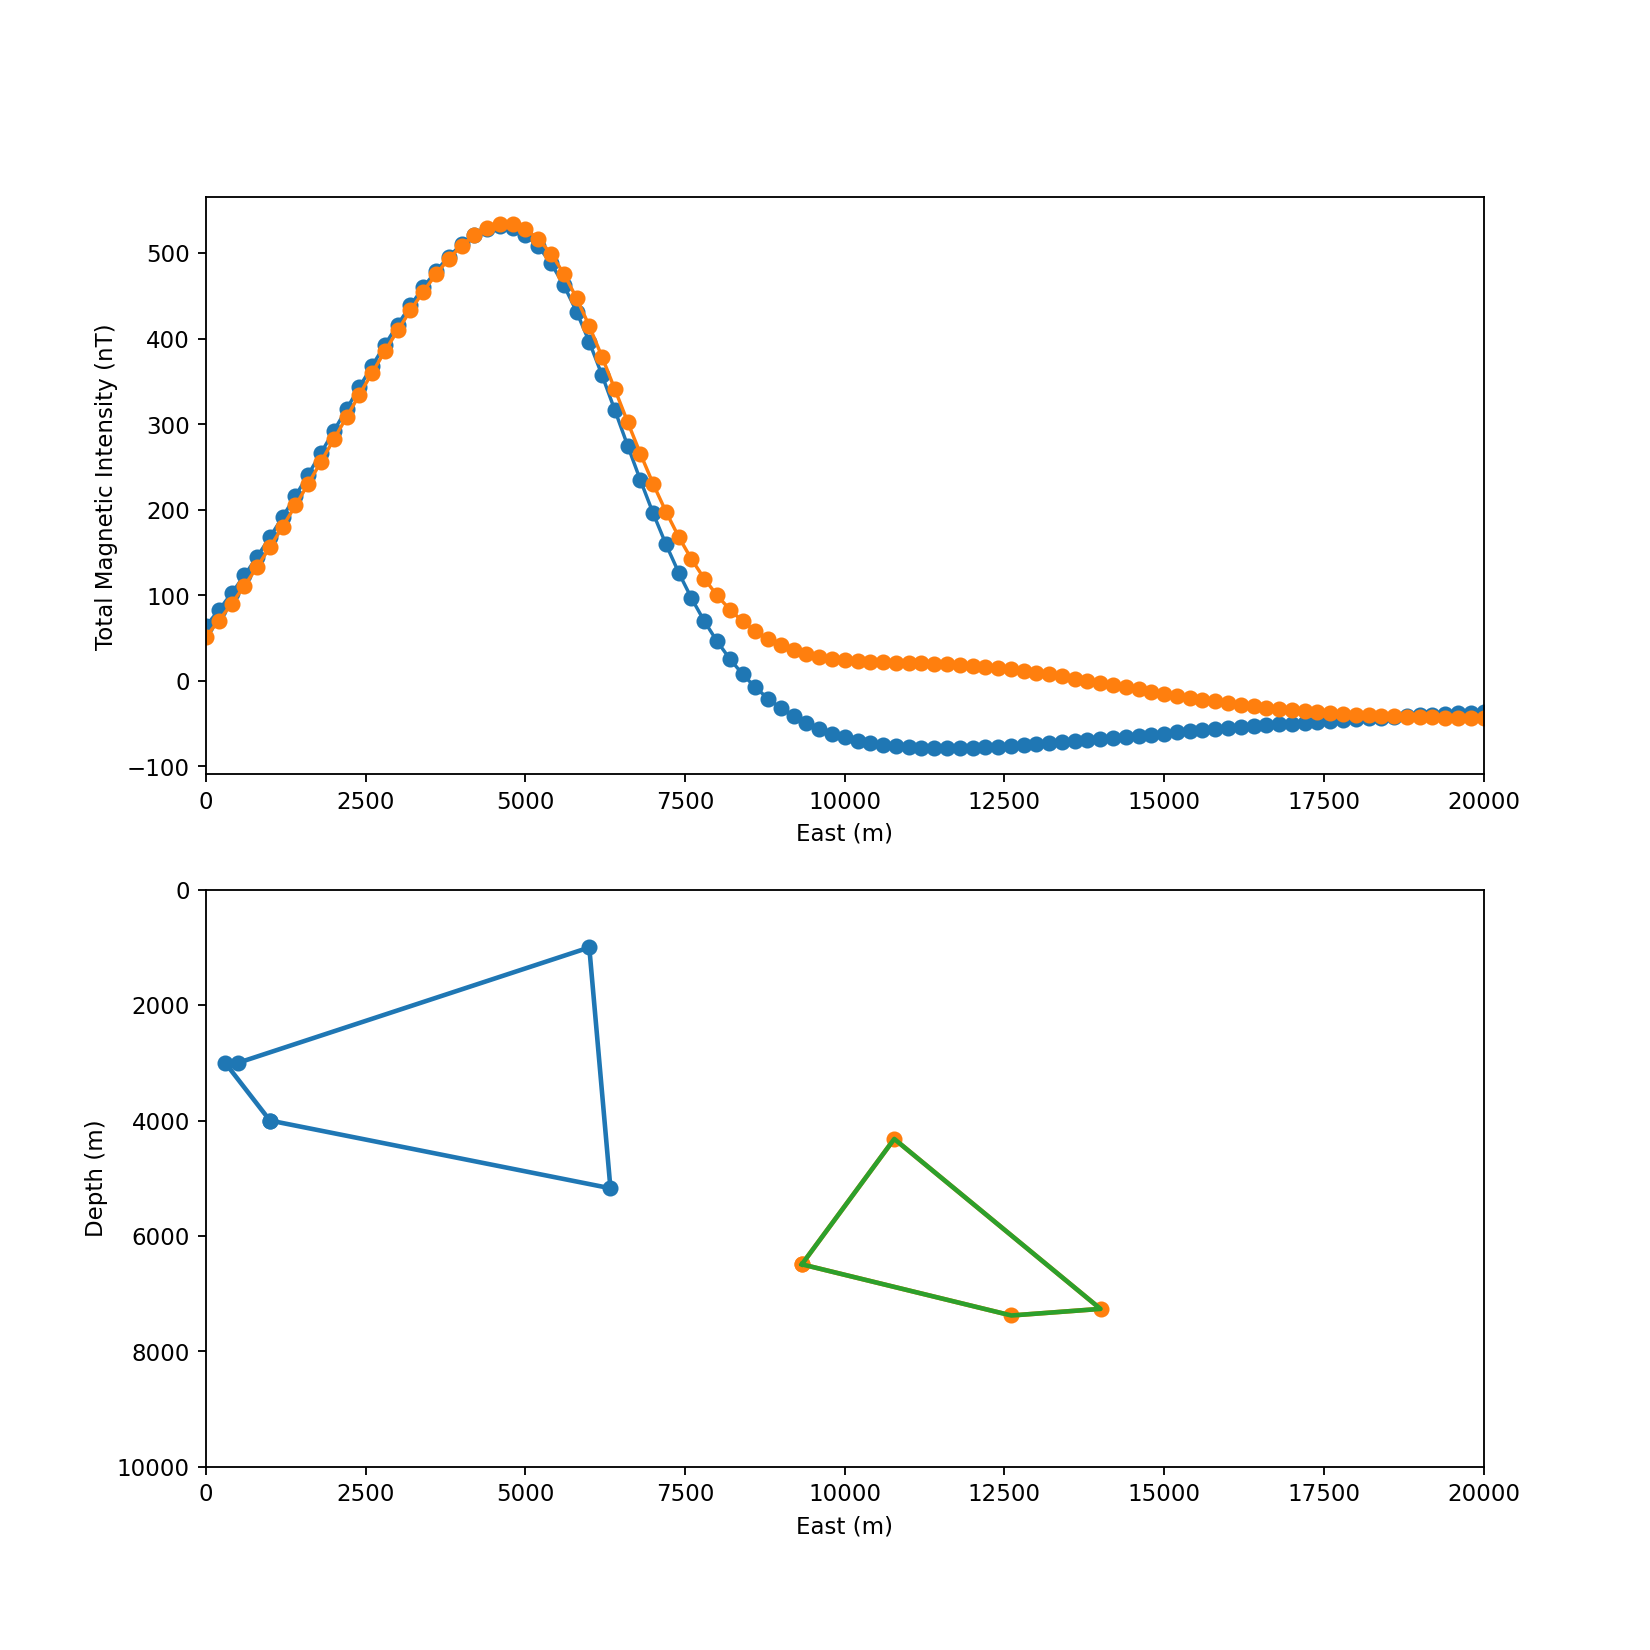

IntSlider(value=1000, description='Flight_height_above_ground:', max=10000, step=1000)

Button(description='Add Mag Body', style=ButtonStyle())

Button(description='Clear All Mag Body', style=ButtonStyle())

Button(description='Clear Current Mag Body', style=ButtonStyle())

Button(description='Calculate Mag', style=ButtonStyle())

Button(description='Clear Mag', style=ButtonStyle())

IntSlider(value=4, description='Mangetization 1:', max=10)

IntSlider(value=90, description='Inclination 1:', max=90, min=-90, step=5)

IntSlider(value=0, description='Declination 1:', max=90, min=-90, step=5)

IntSlider(value=4, description='Mangetization 2:', max=10)

IntSlider(value=90, description='Inclination 2:', max=90, min=-90, step=5)

IntSlider(value=0, description='Declination 2:', max=90, min=-90, step=5)

In [12]:


# Set up the plot
fig, (ax1, ax) = plt.subplots(2, 1, figsize=(10, 10))
fig.canvas.mpl_connect('button_press_event', on_click)
line, = ax.plot([], [], linestyle='-', linewidth=2, zorder=-1)

ax.set_xlim(0, 20000)
ax.set_ylim(10000, 0)
ax.set_xlabel('East (m)')
ax.set_ylabel('Depth (m)')

ax1.set_xlim(0, 20000)
ax1.set_xlabel('East (m)')
ax1.set_ylabel('Total Magnetic Intensity (nT)')



# Display buttons and sliders
display(height)

display(add_body_with_sliders_button)
display(clear_button)
display(clear_current_button)
display(update_mag_button)
display(clear_mag_button)

plot_initial_points()


update_line()